In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv("online_shoppers_intention.csv")
print(df.shape)
df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Remove duplicates


In [ ]:
before = len(df)
# Remove identical rows and reset index
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Drop duplicates: {before} -> {after} (removed {before - after})")

Drop duplicates: 12205 -> 12205 (removed 0)


## Convert boolean-like columns to 0/1

In [ ]:
def to01(s):
    #l owercase -> map "true", "1", "t" to 1, and everything else to 0
    return s.map(lambda x: 1 if str(x).strip().lower() in ["true", "1", "t"] else 0).astype("int8")

# apply conversion to both Weekend and Revenue
for col in ["Weekend", "Revenue"]:
    df[col] = to01(df[col])

# check unique values to make sure only 0 and 1 remain
print(df[["Weekend", "Revenue"]].nunique())

Weekend    2
Revenue    2
dtype: int64


## Define feature groups

In [ ]:
target = "Revenue" # Target label
y = df[target].astype(int) # Numeric
X = df.drop(columns=[target]) # Features

# Numerical features: continuous or discrete numbers
num_cols = [
    "Administrative","Administrative_Duration","Informational","Informational_Duration",
    "ProductRelated","ProductRelated_Duration","BounceRates","ExitRates","PageValues",
    "SpecialDay","OperatingSystems","Browser","Region","TrafficType"
]

# Categorical features -> One-hot encoding
cat_cols = ["Month", "VisitorType"]

# Boolean column -> already numeric
bool_cols = ["Weekend"]

# Sanity check to ensure columns exist
for c in num_cols + cat_cols + bool_cols:
    assert c in X.columns, f"missing column: {c}"

print("Columns grouped successfully")

Columns grouped successfully


## Encode Month (cyclic features)

Month name -> sin/cos numeric features to represent seasonality



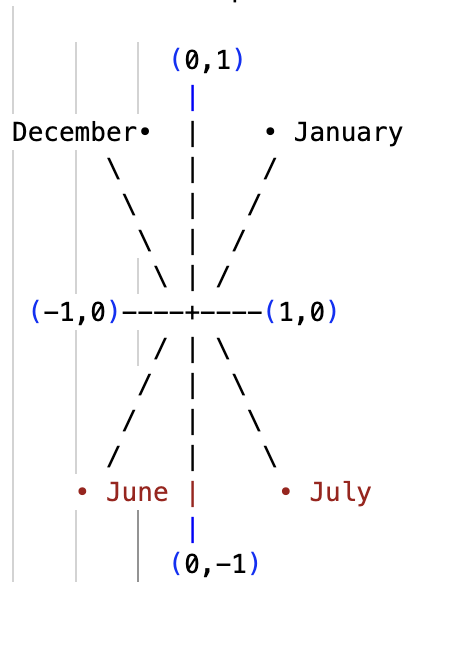


| Month    | sin(2πm/12) | cos(2πm/12) |
| :------- | :---------- | :---------- |
| 1 (Jan)  | 0.5         | 0.866       |
| 3 (Mar)  | 1.0         | 0.0         |
| 6 (Jun)  | 0.0         | -1.0        |
| 9 (Sep)  | -1.0        | 0.0         |
| 12 (Dec) | -0.5        | 0.866       |


Summer(June ~ August) -> similar sin/cos patter

Winter(December ~ Feburary) -> similar sin/cos pattern

In [ ]:
use_month_cyclical = True

# Map each month string to a number
month_order = ["Jan","Feb","Mar","Apr","May","June","Jul","Aug","Sep","Oct","Nov","Dec"]
month_to_num = {m:i+1 for i,m in enumerate(month_order)}

def add_month_cyclical(X_):
    X = X_.copy()
    m = X["Month"].map(month_to_num)
    m = m.fillna(0)
    X["Month_sin"] = np.sin(2*np.pi*m/12) # sin term captures cyclic nature
    X["Month_cos"] = np.cos(2*np.pi*m/12) # cos term captures complementary info
    return X

## Create preprocessing pipeline

In [ ]:
# Numeric columns: fill missing values(median) + standardize

numeric_tf = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "median")), #Fill NaN with median
    ("scaler", StandardScaler()) #Scale to mean = 0, std=1
])

# Categorical columns: fill missing(mode) + one_hot encode
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Replace NaN with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # One-hot, ignore unseen categories
])

if use_month_cyclical:
    #If we use sin/cos for Month, remove it from categorical colums
    cat_cols_eff = [c for c in cat_cols if c!= "Month"]

    #Build a combined pipeline
    preprocess = Pipeline(steps=[
        ("month_cyc", FunctionTransformer(add_month_cyclical, validate=False)),  # Add sin/cos columns
        ("ct", ColumnTransformer(
            transformers=[
                ("num", numeric_tf, num_cols + ["Month_sin","Month_cos"]),  # numeric + month features
                ("cat", categorical_tf, cat_cols_eff),                      # VisitorType only
                ("bool", "passthrough", bool_cols)                          # pass through Weekend (0/1)
            ],
            remainder="drop"   # drop any unused columns
        ))
    ])

else:
    # Simple version using One-Hot for Month
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, num_cols),
            ("cat", categorical_tf, cat_cols),
            ("bool", "passthrough", bool_cols)
        ],
        remainder="drop"
    )

In [ ]:
# Apply preprocessing pipeline to the entire feature set X
# We use fit_transform here because we haven't split the data yet.
X_processed = preprocess.fit_transform(X)

# Extract transformed feature names (for DataFrame columns)
ct = preprocess.named_steps["ct"] if isinstance(preprocess, Pipeline) else preprocess
feature_names = ct.get_feature_names_out()

print("Transformed shape:", X_processed.shape)
print("Number of features:", len(feature_names))

Transformed shape: (12205, 20)
Number of features: 20


In [ ]:
# Convert numpy array to DataFrame for readability
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Add target column back (Revenue)
X_processed_df[target] = y.values

# Check a few rows
print(X_processed_df.head(3))

   num__Administrative  num__Administrative_Duration  num__Informational  \
0            -0.702302                     -0.460019           -0.398824   
1            -0.702302                     -0.460019           -0.398824   
2            -0.702302                     -0.460019           -0.398824   

   num__Informational_Duration  num__ProductRelated  \
0                    -0.246257            -0.696218   
1                    -0.246257            -0.673793   
2                    -0.246257            -0.696218   

   num__ProductRelated_Duration  num__BounceRates  num__ExitRates  \
0                     -0.628793          3.969402        3.434394   
1                     -0.595451         -0.450137        1.268054   
2                     -0.628793          3.969402        3.434394   

   num__PageValues  num__SpecialDay  ...  num__Browser  num__Region  \
0        -0.318962         -0.31024  ...     -0.794017    -0.896370   
1        -0.318962         -0.31024  ...     -0.209237 

In [ ]:
X_processed_df.to_csv("online_shoppers_preprocessed.csv", index=False)
print(" Saved preprocessed dataset as 'online_shoppers_preprocessed.csv'")


 Saved preprocessed dataset as 'online_shoppers_preprocessed.csv'
